# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import random


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset.

In [2]:
# Load and unzip the dataset

zip_path = '/content/drive/MyDrive/CNN/data.zip'  # Replace with your ZIP file path
extract_path = '/content/drive/MyDrive/CNN/'  # Folder to extract into
if not os.path.exists(extract_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [3]:
# Create a function to load the raw images

def load_raw_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # normalize to [0, 1]
    return img_array



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Get the images and their labels

def get_images_and_labels(dataset_dir, target_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                img = load_raw_image(image_path, target_size)
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)


## Found the size from the later part of starter notebook (finding image of smaller and larger dimensions)  
# Resized image initially to 128*128 as session is getting crashed after using all the available RAM


Perform any operations, if needed, on the images and labels to get them into the desired format.

In [5]:
#Verify if the images and labels are loaded correctly.
dataset_dir='/content/drive/MyDrive/CNN/data'
images, labels = get_images_and_labels(dataset_dir, target_size=(128, 128))
print("Loaded", len(images), "images")


Loaded 7625 images


In [ ]:
from collections import Counter

# Get sorted list of class names from subdirectories
class_names = sorted(os.listdir(dataset_dir))

# Count label occurrences
label_counts = Counter(labels)

for label, count in label_counts.items():
    print(f"{label}: {count} images")


Food_Waste: 1000 images
Paper: 1030 images
Cardboard: 540 images
Other: 1010 images
Glass: 750 images
Metal: 1000 images
Plastic: 2295 images


### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [ ]:
# Visualise Data Distribution

import matplotlib.pyplot as plt
from collections import Counter

# Count label occurrences
label_counts = Counter(labels)

# Split into labels and counts
class_labels = list(label_counts.keys())
counts = list(label_counts.values())

# Plot
plt.figure(figsize=(10, 6))
plt.bar(class_labels, counts, color='skyblue')
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

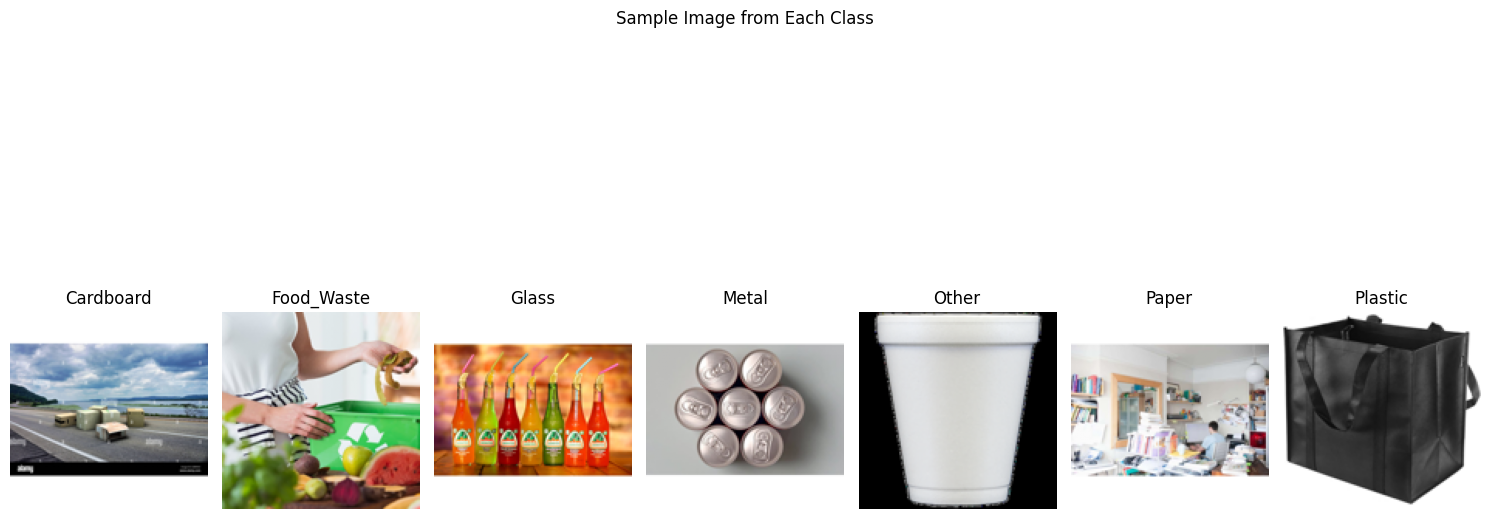

In [ ]:
# Visualise Sample Images (across different labels)

import matplotlib.pyplot as plt
import numpy as np
import random

# Create a dictionary to store one sample per class
samples = {}
for img, label in zip(images, labels):
    if label not in samples:
        samples[label] = img
    if len(samples) == len(set(labels)):
        break  # Stop once we have one per class

# Sort by class name
sorted_samples = dict(sorted(samples.items()))

# Plot
plt.figure(figsize=(15, 8))
for i, (label, img) in enumerate(sorted_samples.items()):
    plt.subplot(1, len(sorted_samples), i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.suptitle("Sample Image from Each Class")
plt.tight_layout()
plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set
from PIL import Image
import os

def find_smallest_largest_dim(dataset_dir):
    min_shape = (float('inf'), float('inf'))  # (height, width)
    max_shape = (0, 0)

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    w, h = img.size  # PIL gives (width, height)
                    min_shape = (min(min_shape[0], h), min(min_shape[1], w))
                    max_shape = (max(max_shape[0], h), max(max_shape[1], w))
            except Exception as e:
                print(f"Error reading {image_path}: {e}")

    return min_shape, max_shape

min_shape, max_shape = find_smallest_largest_dim(dataset_dir)

print(f"Smallest original image size: {min_shape[0]} x {min_shape[1]}")
print(f"Largest original image size: {max_shape[0]} x {max_shape[1]}")


Smallest original image size: 256 x 256
Largest original image size: 256 x 256


In [ ]:
# Resize the image dimensions
# Resize step has already been applied during image loading using:
# img = img.resize((128, 128))
# No additional resizing is done here.

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [6]:
# Encode the labels suitably
from sklearn.preprocessing import LabelEncoder

# Label Encoding after resizing images
def encode_labels(labels):
    le= LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    return encoded_labels, le.classes_

# Encode labels
encoded_labels, class_names = encode_labels(labels)

print(f"Encoded labels shape: {encoded_labels.shape}")
print(f"Class names: {class_names}")


Encoded labels shape: (7625,)
Class names: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [7]:
# Assign specified parts of the dataset to train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels,
    test_size=0.3,
    random_state=42,
    stratify=encoded_labels
)



## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [14]:
# Build and compile the model

## CONFIG1 [Added 3 Convolutional layers and one Dense layer resulted about 37% accuracy]

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)
num_classes = 7
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')  # Output layer
])


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,183 (1.56 MB)

 Trainable params: 408,071 (1.56 MB)

 Non-trainable params: 112 (448.00 B)

In [17]:
# To improve accuracy adding additional dense layers and changed hyperparametrs

## CONFIG2 (ACCURACY ~44%)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)
num_classes = 7

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),

    Dense(256, activation='relu'),  # New dense layer
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,550,727 (24.99 MB)

 Trainable params: 6,550,279 (24.99 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
## Tuing hyperparameters to improve accuracy 
## CONFIG 3 [ACCURACY ~54%]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)
num_classes = 7
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Output layer
])


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 836,135 (3.19 MB)

 Trainable params: 835,911 (3.19 MB)

 Non-trainable params: 224 (896.00 B)

In [14]:
## CONFIG 4 [ACCURACY ~60] Changed number of neurons in dense layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)
num_classes = 7
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Output layer
])


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,615 (6.35 MB)

 Trainable params: 1,664,391 (6.35 MB)

 Non-trainable params: 224 (896.00 B)

In [8]:
## CONFIG 5 [ACCURACY ~65%] [Added dropouts to prevent any overfitting ]
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)
num_classes = 7
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Output layer
])


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 723,175 (2.76 MB)

 Trainable params: 722,695 (2.76 MB)

 Non-trainable params: 480 (1.88 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
# Training MODEL WITH CONFIG1
import tensorflow
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[
        tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 446ms/step - accuracy: 0.2059 - loss: 2.8862 - val_accuracy: 0.0983 - val_loss: 4.5123
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 71s 426ms/step - accuracy: 0.2515 - loss: 1.9331 - val_accuracy: 0.1219 - val_loss: 3.1109
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 70s 420ms/step - accuracy: 0.2730 - loss: 1.8882 - val_accuracy: 0.2758 - val_loss: 2.1120
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 72s 428ms/step - accuracy: 0.2836 - loss: 1.8891 - val_accuracy: 0.3086 - val_loss: 1.9411
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 71s 426ms/step - accuracy: 0.2914 - loss: 1.8240 - val_accuracy: 0.3322 - val_loss: 1.8457
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 71s 427ms/step - accuracy: 0.3115 - loss: 1.7954 - val_accuracy: 0.3505 - val_loss: 1.8338
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 72s 430ms/step - accuracy: 0.3311 - loss: 1.7484 - val_accuracy: 0.3619 - val_loss: 1.8318
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 73s 434ms/step - accuracy: 0.3308 - loss: 1

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.3f}")
print(f"Validation Accuracy: {accuracy:.3f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3578 - loss: 1.8329
Validation Loss: 1.832
Validation Accuracy: 0.362


In [ ]:
# Training MODEL WITH CONFIG2
import tensorflow
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[
        tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.2061 - loss: 2.8083 - val_accuracy: 0.1324 - val_loss: 5.5591
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.2856 - loss: 1.8444 - val_accuracy: 0.2024 - val_loss: 2.6337
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.3140 - loss: 1.7851 - val_accuracy: 0.3287 - val_loss: 2.2123
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.3400 - loss: 1.7777 - val_accuracy: 0.3505 - val_loss: 2.1072
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.3474 - loss: 1.7184 - val_accuracy: 0.3955 - val_loss: 1.8554
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.3677 - loss: 1.7058 - val_accuracy: 0.4056 - val_loss: 1.8120
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.3663 - loss: 1.6688 - val_accuracy: 0.3990 - val_loss: 1.7965
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.3811 - loss: 1.6410 - val_accu

In [13]:
# Training MODEL WITH CONFIG3
import tensorflow
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[
        tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.2275 - loss: 2.1185 - val_accuracy: 0.1053 - val_loss: 2.2786
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3330 - loss: 1.7404 - val_accuracy: 0.2784 - val_loss: 1.8459
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3663 - loss: 1.6721 - val_accuracy: 0.3549 - val_loss: 1.6809
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3816 - loss: 1.6178 - val_accuracy: 0.4244 - val_loss: 1.5521
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4101 - loss: 1.5511 - val_accuracy: 0.4135 - val_loss: 1.5945
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4277 - loss: 1.5011 - val_accuracy: 0.4515 - val_loss: 1.4972
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4400 - loss: 1.4625 - val_accuracy: 0.4624 - val_loss: 1.4985
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4645 - loss: 1.4102 - val_acc

In [16]:
# Training MODEL WITH CONFIG4
import tensorflow
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[
        tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.2565 - loss: 2.0330 - val_accuracy: 0.1320 - val_loss: 2.2020
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3830 - loss: 1.6366 - val_accuracy: 0.2880 - val_loss: 1.9604
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4420 - loss: 1.5035 - val_accuracy: 0.3851 - val_loss: 1.6779
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4579 - loss: 1.4313 - val_accuracy: 0.4882 - val_loss: 1.4327
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5158 - loss: 1.3277 - val_accuracy: 0.4834 - val_loss: 1.4132
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5406 - loss: 1.2380 - val_accuracy: 0.5450 - val_loss: 1.2731
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5834 - loss: 1.1682 - val_accuracy: 0.5380 - val_loss: 1.3107
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6043 - loss: 1.0745 - val_acc

In [13]:
# Training MODEL WITH CONFIG5
import tensorflow
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[
        tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7430 - loss: 0.7141 - val_accuracy: 0.6342 - val_loss: 1.0774
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7517 - loss: 0.6939 - val_accuracy: 0.6115 - val_loss: 1.1480
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7484 - loss: 0.6869 - val_accuracy: 0.6193 - val_loss: 1.1059
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7638 - loss: 0.6609 - val_accuracy: 0.6447 - val_loss: 1.0626
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7961 - loss: 0.5992 - val_accuracy: 0.6254 - val_loss: 1.1338
Epoch 6/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8065 - loss: 0.5522 - val_accuracy: 0.6464 - val_loss: 1.0793
Epoch 7/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8192 - loss: 0.5316 - val_accuracy: 0.6250 - val_loss: 1.1763


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [14]:
# Evaluate on the test set; display suitable metrics ((final model with config5))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.3f}")
print(f"Validation Accuracy: {accuracy:.3f}")


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6464 - loss: 1.0666
Validation Loss: 1.063
Validation Accuracy: 0.645


In [ ]:
# OVERAL ACHIEVED VALIDATION ACCURACY OF 64.5%

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [11]:
# Define augmentation steps to augment images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the augmentation steps
augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [12]:
# Create a function to augment the images

def show_aug_images(image_array, augmentor, num_images=5):
    import matplotlib.pyplot as plt
    aug_iter = augmentor.flow(image_array.reshape((1, *image_array.shape)), batch_size=1)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        aug_image = next(aug_iter)[0]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(aug_image)
        plt.axis('off')
    plt.show()


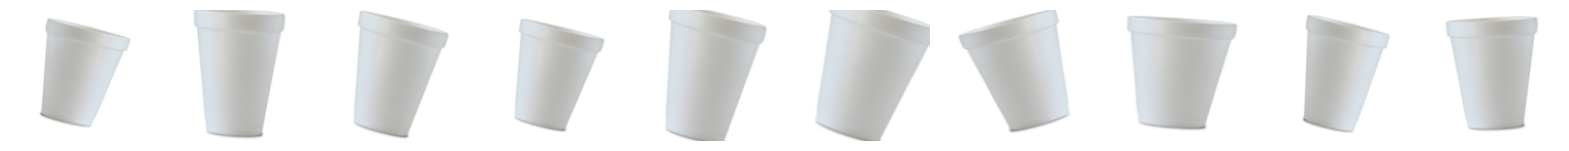

In [13]:
show_aug_images(X_train[13], augmentor,10)

In [13]:
show_aug_images(X_train[3], augmentor)

In [14]:
# Create the augmented training dataset

steps_per_epoch = len(X_train) // 32  # assuming batch size of 32
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 166


##### **4.1.2**

Train the model on the new augmented dataset.

In [15]:
# Train the model using augmented images

history = model.fit(
    augmentor.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[
        tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.5694 - loss: 1.2337 - val_accuracy: 0.6088 - val_loss: 1.1264
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5787 - loss: 1.1633 - val_accuracy: 0.6018 - val_loss: 1.1593
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6010 - loss: 1.1024 - val_accuracy: 0.6416 - val_loss: 1.0737
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6031 - loss: 1.0951 - val_accuracy: 0.6263 - val_loss: 1.0988
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6146 - loss: 1.0826 - val_accuracy: 0.6499 - val_loss: 1.0509
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6233 - loss: 1.0583 - val_accuracy: 0.6110 - val_loss: 1.1374
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.6162 - loss: 1.0457 - val_accuracy: 0.6031 - val_loss: 1.1534
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6346 - loss: 1.0067 - val_accu

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.3f}")
print(f"Validation Accuracy: {accuracy:.3f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.6540 - loss: 1.0481
Validation Loss: 1.051
Validation Accuracy: 0.650


In [ ]:
# POST AUGMENTATION ACCURACY WAS IMPROVED BY JUST 0.5

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

In [17]:
# Results before performing augumentation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=class_names))


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step


              precision    recall  f1-score   support

   Cardboard       0.79      0.70      0.74       162
  Food_Waste       0.67      0.76      0.71       300
       Glass       0.60      0.58      0.59       225
       Metal       0.70      0.58      0.64       300
       Other       0.61      0.50      0.55       303
       Paper       0.54      0.56      0.55       309
     Plastic       0.67      0.75      0.71       689

    accuracy                           0.65      2288
   macro avg       0.65      0.63      0.64      2288
weighted avg       0.65      0.65      0.65      2288



In [ ]:
# After training and evaluating the convolutional neural network (CNN) model,
# the classification performance was assessed using precision, recall, and F1-score
# for each of the seven classes. The model achieved an overall accuracy of 65% on the test dataset

Overall Metrics
*   Overall Accuracy: 65%
*   Macro Average F1-Score: 0.64 (average across all classes )
*   Weighted Average F1-Score: 0.65 (with support into account)


#Summary

Best Performing Classes:
Cardboard, Plastic, and Food_Waste achieved the highest F1-scores (above 0.70), indicating the model is effectively able to identify these classes with a good balance of precision and recall.

Moderate Performing Classes:
Glass, Metal, and Other showed reasonable performance but with lower recall or precision, suggesting some level of confusion with other similar classes.

Lowest Performing Class:
Paper showed the lowest precision and recall values, highlighting it as a challenging class for the model to distinguish accurately.

The macro-averaged F1-score was 0.64, and the weighted average F1-score was also 0.65, reflecting consistent performance across most classes, even considering the varying number of samples per class.

This custom model shows promising results with current techniques but can be improved using fine tuning hyperparametrs or by adding weights or using pre trained models (transfer learning )

In [19]:
#Adding class weights so to improve class balance (But didnt improve accuracy)
# history = model.fit(
#     augmentor.flow(X_train, y_train, batch_size=32),
#     epochs=10,
#     validation_data=(X_test, y_test),
#     class_weight=class_weights_dict,
#     callbacks=[
#         tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
#     ]
# )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.6040 - loss: 1.0790 - val_accuracy: 0.5905 - val_loss: 1.1882
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.6029 - loss: 1.0949 - val_accuracy: 0.6233 - val_loss: 1.0969
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5892 - loss: 1.0805 - val_accuracy: 0.5883 - val_loss: 1.1869
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.6167 - loss: 1.0109 - val_accuracy: 0.6058 - val_loss: 1.1397
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6322 - loss: 0.9874 - val_accuracy: 0.6184 - val_loss: 1.1284


In [20]:
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Validation Loss: {loss:.3f}")
# print(f"Validation Accuracy: {accuracy:.3f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.6284 - loss: 1.1054
Validation Loss: 1.097
Validation Accuracy: 0.623


In [22]:
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# print(classification_report(y_test, y_pred_classes, target_names=class_names))


72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step
              precision    recall  f1-score   support

   Cardboard       0.67      0.69      0.68       162
  Food_Waste       0.67      0.74      0.70       300
       Glass       0.62      0.58      0.60       225
       Metal       0.53      0.72      0.61       300
       Other       0.51      0.52      0.52       303
       Paper       0.52      0.58      0.55       309
     Plastic       0.79      0.59      0.68       689

    accuracy                           0.62      2288
   macro avg       0.62      0.63      0.62      2288
weighted avg       0.64      0.62      0.63      2288

